In [145]:
import pandas as pd 
import zipfile

### loading the data

# zip file containing all data
zip_path = 'data.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # extract all the contents into the current directory
    zip_ref.extractall()

# loading the data file
df_pressure = pd.read_parquet('./data.parquet')
# check if it's loaded correctly
print(df_pressure.head())
print(df_pressure.info())
print(df_pressure.describe())

# loading the labels file
df_labels = pd.read_csv('./labels.csv')
# check if it's loaded correctly
print(df_labels.head())
print(df_labels.describe())

  MachineId  MeasurementId  Pressure
0     0_0_0              0       0.0
1     0_0_0              0       0.0
2     0_0_0              0       0.0
3     0_0_0              0       0.0
4     0_0_0              0       0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB
None
       MeasurementId      Pressure
count   1.846636e+07  1.846636e+07
mean    3.398397e+03  3.338926e-01
std     3.019365e+03  4.862787e-01
min    -1.000000e+00  0.000000e+00
25%    -1.000000e+00  0.000000e+00
50%     3.179000e+03  0.000000e+00
75%     6.277000e+03  7.017707e-01
max     8.834000e+03  6.774464e+00
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd
0     0_0_0              0      False     False   False
1     0_0_1             -1  

In [146]:
### data cleanup
# encoding MachineId as categorical variable
df_pressure['MachineId'] = df_pressure['MachineId'].astype('category').cat.codes
df_labels['MachineId'] = df_labels['MachineId'].astype('category').cat.codes
print(df_pressure.info())
print(df_labels.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      int16  
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int16(1), int64(1)
memory usage: 317.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27385 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      27385 non-null  int16 
 1   MeasurementId  27385 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int16(1), int64(1), object(3)
memory usage: 909.4+ KB
None


In [147]:
### feature engineering
# fucntion to create features for each measured cycle
def create_features(group):
    half = len(group) // 2
    first_half = group.iloc[:half]
    second_half = group.iloc[half:]
    min_pressure_index = first_half['Pressure'].idxmin()

    # basic statistical features
    features = {
        'Pressure_mean_first_half': first_half['Pressure'].mean(),
        'Time_to_min_pressure_first_half': min_pressure_index,
        'Pressure_std_first_half': first_half['Pressure'].std(),
    }

    # max pressure drop in the first half
    window_size = 5  
    rolling_max = first_half['Pressure'].rolling(window=window_size).max()
    rolling_min = first_half['Pressure'].rolling(window=window_size).min()
    features['Max_pressure_drop_first_half'] = (rolling_max - rolling_min).max()

    return pd.Series(features)


In [148]:
# aggregate features
df_features = df_pressure.groupby(['MachineId', 'MeasurementId']).apply(create_features).reset_index()

# check results
print(df_features.head())
print(df_labels.head())

# merge the dataframes
df_merged = pd.merge(df_features, df_labels, on=['MachineId', 'MeasurementId'], how='inner')

# check
print(df_merged.head())

   MachineId  MeasurementId  Pressure_mean_first_half  \
0          0             -1                  0.230289   
1          0              0                  0.605873   
2          0            215                  0.710727   
3          0            237                  0.977540   
4          0            353                  0.344599   

   Time_to_min_pressure_first_half  Pressure_std_first_half  \
0                          15396.0                 0.415121   
1                              0.0                 0.582492   
2                         491116.0                 0.729057   
3                         549924.0                 0.706656   
4                         822660.0                 0.390084   

   Max_pressure_drop_first_half  
0                      2.439888  
1                      1.413592  
2                      0.822092  
3                      1.110902  
4                      0.764820  
   MachineId  MeasurementId PumpFailed SlowStart SlowEnd
0          0     

In [149]:
### further data cleanup
# remove rows where PumpFailed is NaN
df_cleaned = df_merged.dropna(subset=['PumpFailed']).copy()

# check the cleaned dataframe
print(df_cleaned.dtypes)

# convert PumpFailed to integer
df_cleaned['PumpFailed'] = df_cleaned['PumpFailed'].astype(int)

# check data types
print(df_cleaned.dtypes)
print(df_cleaned['PumpFailed'].unique())

MachineId                            int16
MeasurementId                        int64
Pressure_mean_first_half           float64
Time_to_min_pressure_first_half    float64
Pressure_std_first_half            float64
Max_pressure_drop_first_half       float64
PumpFailed                          object
SlowStart                           object
SlowEnd                             object
dtype: object
MachineId                            int16
MeasurementId                        int64
Pressure_mean_first_half           float64
Time_to_min_pressure_first_half    float64
Pressure_std_first_half            float64
Max_pressure_drop_first_half       float64
PumpFailed                           int64
SlowStart                           object
SlowEnd                             object
dtype: object
[0 1]


In [150]:
# check for missing values in each column
missing_values = df_cleaned.isna().sum()
print(missing_values)

# drop rows where either SlowStart or SlowEnd have missing values
df_cleaned_no_missing = df_cleaned.dropna(subset=['SlowStart', 'SlowEnd']).copy()

# convert SlowStart and SlowEnd to integer
df_cleaned_no_missing['SlowStart'] = df_cleaned_no_missing['SlowStart'].astype(int)
df_cleaned_no_missing['SlowEnd'] = df_cleaned_no_missing['SlowEnd'].astype(int)

# check the result
print(df_cleaned_no_missing.isna().sum())
print(df_cleaned_no_missing.info())

MachineId                             0
MeasurementId                         0
Pressure_mean_first_half              0
Time_to_min_pressure_first_half       0
Pressure_std_first_half               0
Max_pressure_drop_first_half          0
PumpFailed                            0
SlowStart                          7600
SlowEnd                            7600
dtype: int64
MachineId                          0
MeasurementId                      0
Pressure_mean_first_half           0
Time_to_min_pressure_first_half    0
Pressure_std_first_half            0
Max_pressure_drop_first_half       0
PumpFailed                         0
SlowStart                          0
SlowEnd                            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 19300 entries, 1 to 27384
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MachineId                        19300 non-null  

In [152]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

### data preparation for modelling
# prepare the data
X = df_cleaned_no_missing[['Pressure_mean_first_half', 'Time_to_min_pressure_first_half', 'Pressure_std_first_half', 'Max_pressure_drop_first_half', 'SlowStart', 'SlowEnd']] # features
y = df_cleaned_no_missing['PumpFailed'] # target

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
from sklearn.ensemble import RandomForestClassifier

### classification
# random forest classifier - good for imbalanced datasets
# this dataset is imbalanced because in most of the cases PumpFailed is False
# PumpFailed = True is a minority class
# class_weight='balanced' to adjust weights inversely proportional to class frequencies - giving more importance to the PumpFailed = True class
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [154]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

### model evaluation
# predictions
y_pred = model.predict(X_test)

# model evaluation
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
# the precision for PumpFailed = False is good
# precision for the minority class is not great
# adjusting the decision threshold might help

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3444
           1       0.49      0.39      0.43       416

    accuracy                           0.89      3860
   macro avg       0.71      0.67      0.69      3860
weighted avg       0.88      0.89      0.88      3860

Accuracy: 0.8904145077720207
ROC AUC Score: 0.6701761145358706


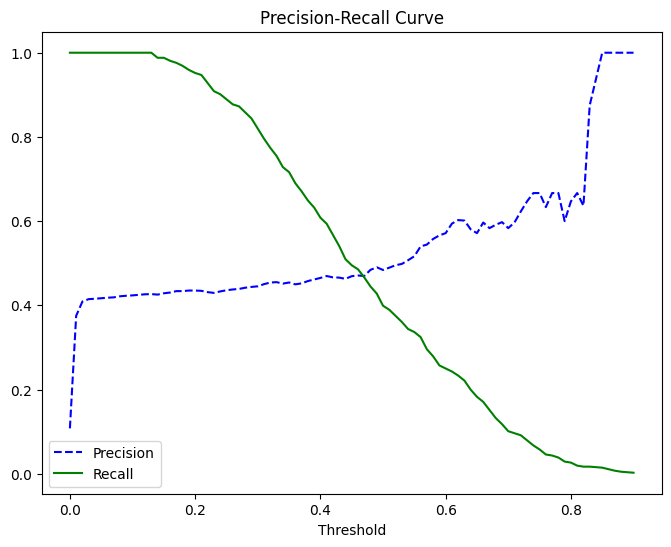

In [156]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

### model improvement
# extracting predicted probabilities
y_probs = model.predict_proba(X_test) 

# y_probs is a 2D array with probabilities for class 0 and class 1
# we are interested in the probabilities of class 1
y_probs_class1 = y_probs[:, 1]

# calculate precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_class1)

# plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.show()

In [157]:
# changing the threshold to maximize recall without sacrificing too much precision
threshold = 0.2 

# probabilities to binary predictions based on the threshold
y_pred_custom_threshold = (y_probs_class1 >= threshold).astype(int)

# re-evaluation of model performance
print(classification_report(y_test, y_pred_custom_threshold))
print("Accuracy:", accuracy_score(y_test, y_pred_custom_threshold))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_custom_threshold))

# model is now better at identifying actual failures but also makes more false predictions of failure
# improvement in the ability to distinguish between failures and non-failures (AUC)
# works well if it's crucial to identify nearly all actual failures (even at the cost of more false alarms)

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3444
           1       0.44      0.95      0.60       416

    accuracy                           0.86      3860
   macro avg       0.71      0.90      0.76      3860
weighted avg       0.93      0.86      0.88      3860

Accuracy: 0.8616580310880829
ROC AUC Score: 0.9013390065219333


In [158]:
# extracting the importance of different features
feature_importances = model.feature_importances_
features = X.columns

# looking at them
print(features, feature_importances)
# model relies heavily on Time_to_min_pressure_first_half and less on Pressure_mean_first_half, Max_pressure_drop_first_half and Pressure_std_first_half
# SlowStart and SlowEnd have lower importance

Index(['Pressure_mean_first_half', 'Time_to_min_pressure_first_half',
       'Pressure_std_first_half', 'Max_pressure_drop_first_half', 'SlowStart',
       'SlowEnd'],
      dtype='object') [0.07388672 0.63485031 0.07257654 0.0798937  0.03743831 0.10135443]
